In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '04'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, display_data, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [24]:
idx_explain = 1000

In [4]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [25]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood,
                                              dtc_max_depth=3)

CPU times: user 31.1 s, sys: 243 ms, total: 31.3 s
Wall time: 31.6 s


In [26]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1562,  618]))


In [27]:
value = 0
width = X.shape[0]
filler_feature_values = {1: value, 3: value, 4: value, 5: value, 6: value, 7: value, 8: value, 9: value, 10: value, 11: value}
filler_feature_ranges = {1: width, 3: width, 4: width, 5: width, 6: width, 7: width, 8: width, 9: width, 10: width, 11: width}

No contour levels were found within the data range.
Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


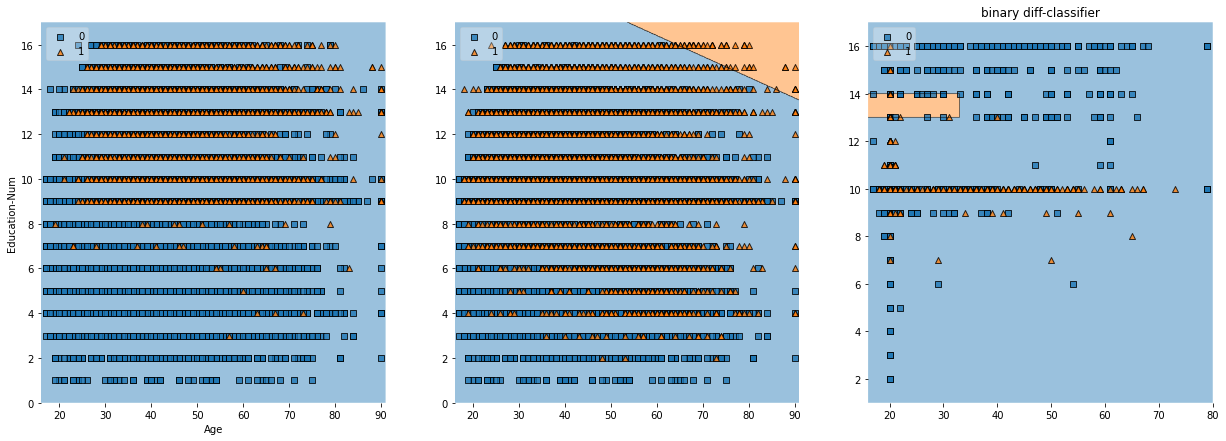

In [28]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.integer), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('binary diff-classifier')

plt.show()

[Text(465.0, 792.75, 'Education-Num <= 12.5\ngini = 0.406\nsamples = 2180\nvalue = [1562, 618]\nclass = no_diff'),
 Text(232.5, 566.25, 'Sex <= 0.5\ngini = 0.496\nsamples = 1312\nvalue = [715, 597]\nclass = no_diff'),
 Text(116.25, 339.75, 'Relationship <= 3.5\ngini = 0.119\nsamples = 378\nvalue = [354, 24]\nclass = no_diff'),
 Text(58.125, 113.25, 'gini = 0.043\nsamples = 320\nvalue = [313, 7]\nclass = no_diff'),
 Text(174.375, 113.25, 'gini = 0.414\nsamples = 58\nvalue = [41, 17]\nclass = no_diff'),
 Text(348.75, 339.75, 'Relationship <= 2.5\ngini = 0.474\nsamples = 934\nvalue = [361, 573]\nclass = diff'),
 Text(290.625, 113.25, 'gini = 0.083\nsamples = 115\nvalue = [110, 5]\nclass = no_diff'),
 Text(406.875, 113.25, 'gini = 0.425\nsamples = 819\nvalue = [251, 568]\nclass = diff'),
 Text(697.5, 566.25, 'Education-Num <= 13.5\ngini = 0.047\nsamples = 868\nvalue = [847, 21]\nclass = no_diff'),
 Text(581.25, 339.75, 'Age <= 32.0\ngini = 0.267\nsamples = 82\nvalue = [69, 13]\nclass = no_

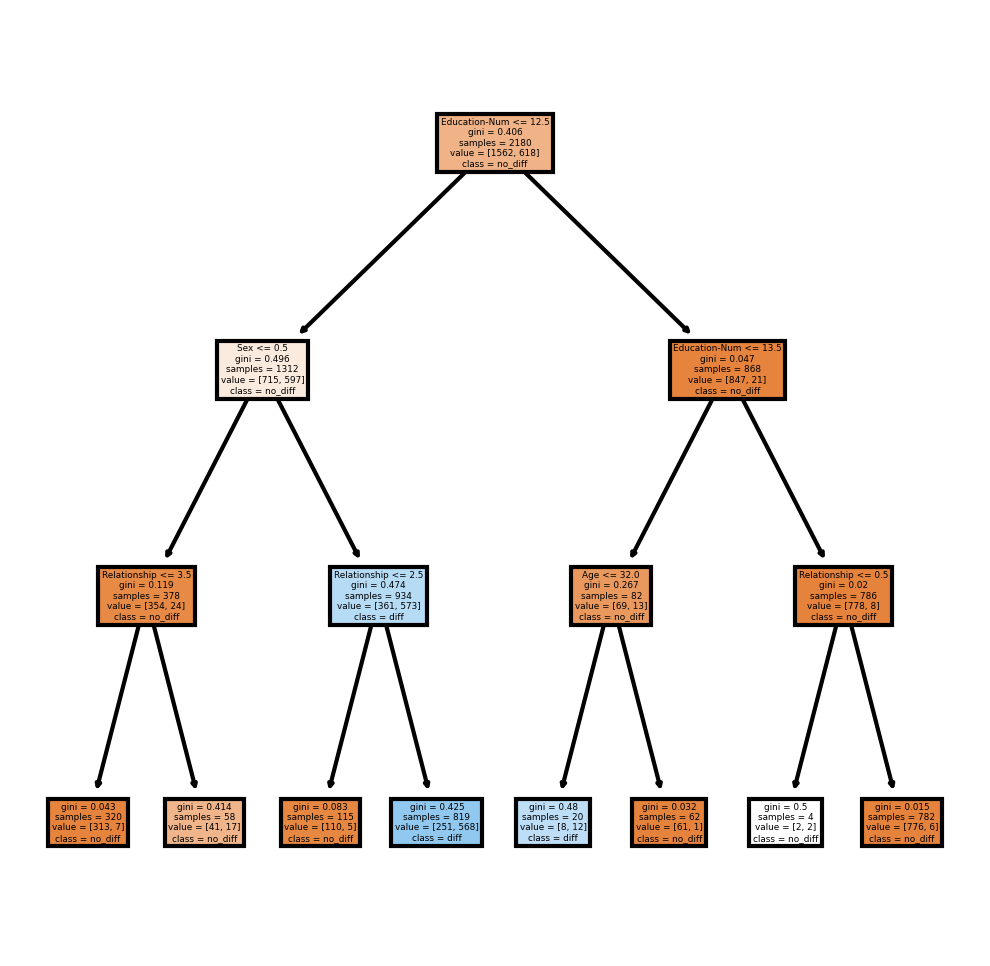

In [29]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [30]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{Education-Num <= 12.5, Sex > 0.5, Relationship > 2.5}'}
{'diff': '{Education-Num > 12.5, Education-Num <= 13.5, Age <= 32.0}'}


## Multiclass difference explanations

In [11]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [12]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

CPU times: user 30.2 s, sys: 203 ms, total: 30.4 s
Wall time: 30.4 s


In [13]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([534, 376, 896]))


No contour levels were found within the data range.


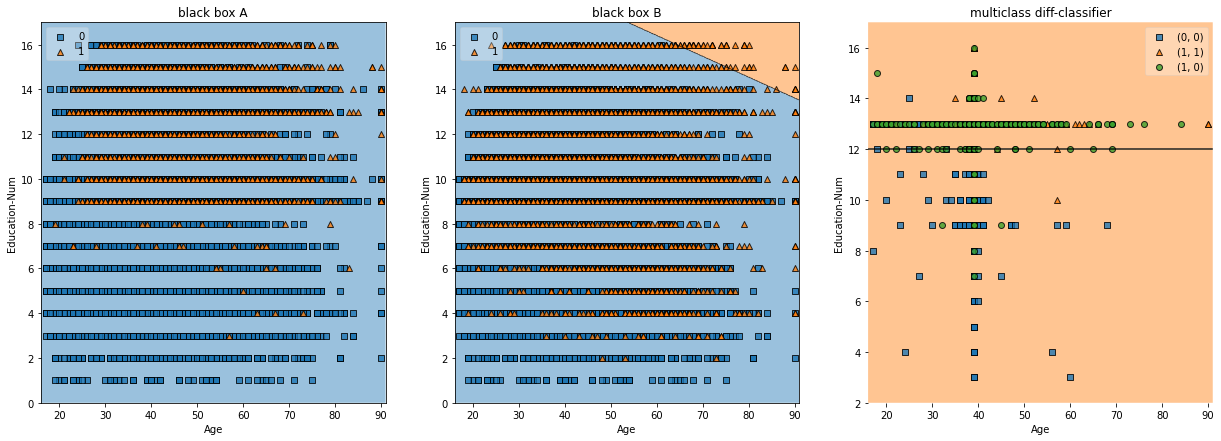

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[2])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.int64), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[2])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(465.0, 792.75, 'Relationship <= 2.5\ngini = 0.623\nsamples = 1806\nvalue = [534, 376, 896]\nclass = (1, 0)'),
 Text(232.5, 566.25, 'Education-Num <= 11.5\ngini = 0.482\nsamples = 1347\nvalue = [532, 5, 810]\nclass = (1, 0)'),
 Text(116.25, 339.75, 'Capital Gain <= 7493.0\ngini = 0.032\nsamples = 307\nvalue = [302, 0, 5]\nclass = (0, 0)'),
 Text(58.125, 113.25, '\n  (...)  \n'),
 Text(174.375, 113.25, '\n  (...)  \n'),
 Text(348.75, 339.75, 'Sex <= 0.5\ngini = 0.352\nsamples = 1040\nvalue = [230, 5, 805]\nclass = (1, 0)'),
 Text(290.625, 113.25, '\n  (...)  \n'),
 Text(406.875, 113.25, '\n  (...)  \n'),
 Text(697.5, 566.25, 'Sex <= 0.5\ngini = 0.312\nsamples = 459\nvalue = [2, 371, 86]\nclass = (1, 1)'),
 Text(581.25, 339.75, 'Marital Status <= 3.0\ngini = 0.451\nsamples = 75\nvalue = [2, 22, 51]\nclass = (1, 0)'),
 Text(523.125, 113.25, '\n  (...)  \n'),
 Text(639.375, 113.25, '\n  (...)  \n'),
 Text(813.75, 339.75, 'Education-Num <= 11.5\ngini = 0.166\nsamples = 384\nvalue = [0,

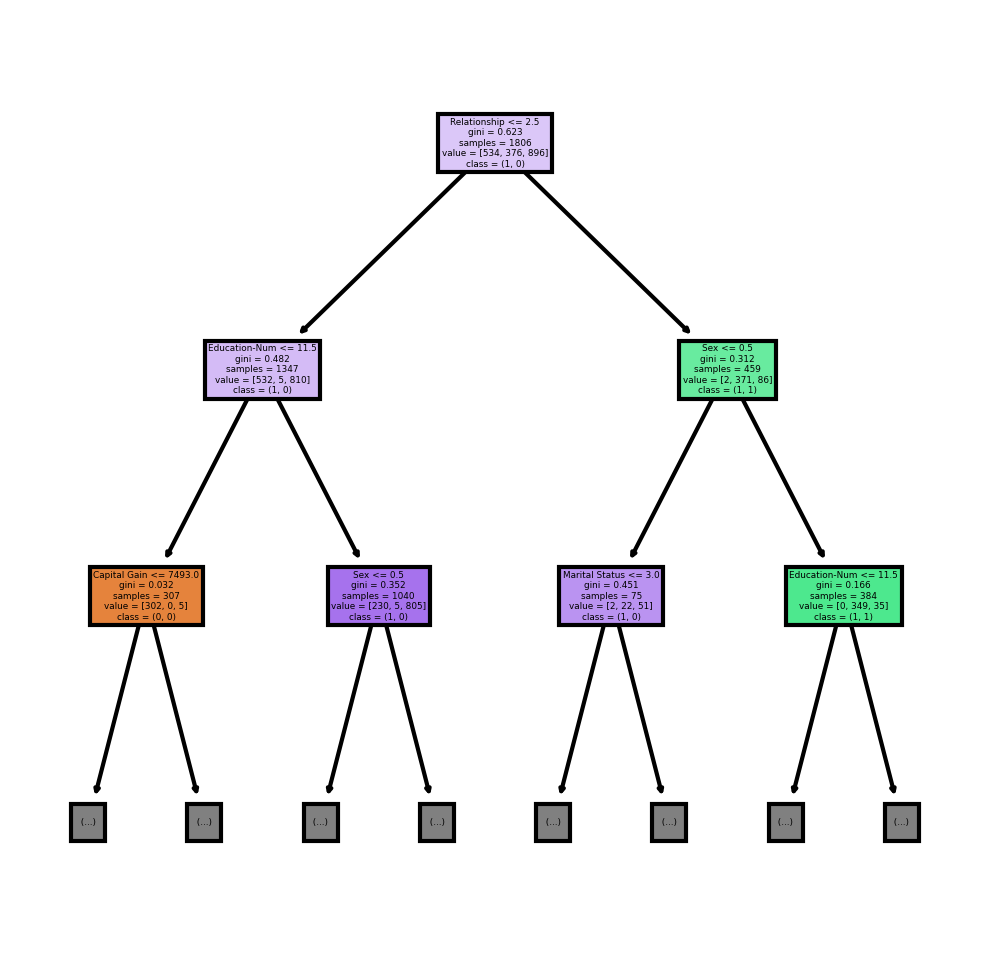

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True, max_depth=2)